In [1]:
!nvidia-smi

Sat Feb 15 14:02:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import os 
os.chdir("/kaggle/input/teste-diffusers")

In [2]:
!pip install -r "./requirements.txt"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pywin32==308 (from versions: none)
ERROR: No matching distribution found for pywin32==308


In [3]:
import torch
import numpy as np
import cv2

from torchvision import transforms
from huggingface_hub import login

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, UniPCMultistepScheduler
from PIL import Image
from safetensors import safe_open

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
login()

In [5]:
if torch.cuda.is_available():
    device_name = torch.device("cuda")
    torch_dtype = torch.float16
    print("Using CUDA")
else:
    device_name = torch.device("cpu")
    torch_dtype = torch.float32
    print("Using CPU")

Using CUDA


In [6]:
class LocalModel:
    def __init__(self, local_path:str, base_model:str, controlnet_seg_model:str, controlnet_dep_model:str, controlnet_edg_model:str) -> None:
        self.local_path = local_path
        self.base_model = base_model
        self.controlnet_seg_model = controlnet_seg_model
        self.controlnet_dep_model = controlnet_dep_model
        self.controlnet_edg_model = controlnet_edg_model

In [10]:
base_path = "./safetensors/{}"
base_path = "/kaggle/input/safetensors/{}"

model_1 = LocalModel(
  local_path=base_path.format("A bird's-eye view of architecture.safetensors"),
  base_model="runwayml/stable-diffusion-v1-5",
  controlnet_seg_model="lllyasviel/control_v11p_sd15_seg",
  controlnet_dep_model="lllyasviel/control_v11f1p_sd15_depth",
  controlnet_edg_model="lllyasviel/control_v11p_sd15_canny"
)
model_2 = LocalModel(
  local_path=base_path.format("AARG_aerial-000018.safetensors"),
  base_model="runwayml/stable-diffusion-v1-5",
  controlnet_seg_model="lllyasviel/control_v11p_sd15_seg",
  controlnet_dep_model="lllyasviel/control_v11f1p_sd15_depth",
  controlnet_edg_model="lllyasviel/control_v11p_sd15_canny"
)
model_3 = LocalModel(
  local_path=base_path.format("aerial view-V2.safetensors"),
  base_model="runwayml/stable-diffusion-v1-5",
  controlnet_seg_model="lllyasviel/control_v11p_sd15_seg",
  controlnet_dep_model="lllyasviel/control_v11f1p_sd15_depth",
  controlnet_edg_model="lllyasviel/control_v11p_sd15_canny"
)
model_4 = LocalModel(
  local_path=base_path.format("FLUXD-Style-Urban_Jungles-urjungle.safetensors"),
  base_model="black-forest-labs/FLUX.1-dev",
  controlnet_seg_model="lllyasviel/control_v11p_sd15_seg",
  controlnet_dep_model="lllyasviel/control_v11f1p_sd15_depth",
  controlnet_edg_model="lllyasviel/control_v11p_sd15_canny"
)

In [ ]:
# https://docs.google.com/spreadsheets/d/1se8YEtb2detS7OuPE86fXGyD269pMycAWe2mtKUj2W8/edit?gid=0#gid=0
# ADE20K Class -> Roads -> #8C8C8C
# ADE20K Class -> Buildings -> #B47878
# ADE20K Class -> Grass -> #04FA07
# ADE20K Class -> Water -> #3DE6FA
# ADE20K Class -> Sidewalk -> #EBFF07
# ADE20K Class -> Sky -> #06E6E6


# Local
model = model_3

controlnet_depth = ControlNetModel.from_pretrained(
    model.controlnet_dep_model, torch_dtype=torch_dtype
).to(device_name)
controlnet_seg = ControlNetModel.from_pretrained(
    model.controlnet_seg_model, torch_dtype=torch_dtype
).to(device_name)
controlnet_edge = ControlNetModel.from_pretrained(
    model.controlnet_edg_model, torch_dtype=torch_dtype
).to(device_name)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model.base_model,
    controlnet=[controlnet_depth, controlnet_seg, controlnet_edge],
    torch_dtype=torch_dtype
).to(device_name)
pipe.load_lora_weights(model.local_path)
pipe.fuse_lora()

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# HF
# controlnet_depth = ControlNetModel.from_pretrained(
#     "lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch_dtype
# ).to(device_name)
# controlnet_seg = ControlNetModel.from_pretrained(
#     "lllyasviel/control_v11p_sd15_seg", torch_dtype=torch_dtype
# ).to(device_name)

# pipe = StableDiffusionControlNetPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5", controlnet=[controlnet_depth, controlnet_seg], torch_dtype=torch_dtype,
#     use_auth_token=True
# ).to(device_name)

# from diffusers import StableDiffusion3Pipeline

# pipe = StableDiffusion3Pipeline.from_pretrained(
#     "stabilityai/stable-diffusion-3.5-large-turbo", torch_dtype=torch_dtype
# ).to(device_name)

In [ ]:
def load_image(image_path, size=(512, 512)):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, size)
    image = Image.fromarray(image)
    return image

In [ ]:
base_image = load_image(image_real)
depth_map = load_image(image_depth)
seg_map = load_image(image_ade20k)
edge_map = load_image(image_edge)

# Convert images to tensors
transform = transforms.ToTensor()
depth_tensor = transform(depth_map).unsqueeze(0)
seg_tensor = transform(seg_map).unsqueeze(0)
edge_tensor = transform(edge_map).unsqueeze(0)

In [ ]:
prompt = """Ultra-realistic aerial view of a modern city, captured from a high-resolution satellite or drone. Skyscrapers, residential areas, roads, and parks are detailed and proportional, with natural lighting and depth. No distortions, warped buildings, or AI artifacts. Clear atmosphere with soft haze near the horizon."""
negative_prompt = "Distorted buildings, warped roads, AI artifacts, unnatural lighting, low detail, fisheye effect."
num_images = 1

# CONTROLNET

In [ ]:
output = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=[depth_tensor, seg_tensor, edge_tensor],
    num_inference_steps=25,
    strength=0.00001,
    guidance_scale=0.00001,
    controlnet_conditioning_scale=[1.0, 1.0, 1.0],
)

In [ ]:
output.images[0]

# IMG 2 IMG

In [ ]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch_dtype
).to("cuda")

In [ ]:
output = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=base_image,
    strength=0.2,  # Controls how much the image should change (0 = minor edits, 1 = full generation)
    guidance_scale=1,  # Higher values enforce the prompt more
    num_inference_steps=50,
)

In [ ]:
output.images[0]

## TESTE SHAKKER

In [44]:
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DPMSolverMultistepScheduler
from diffusers.models import AutoencoderKL
from PIL import Image
import numpy as np

# Load Base Model (Stable Diffusion 1.5 or Realistic Vision V2.0)
base_model = "SG161222/Realistic_Vision_V2.0"

# Load ControlNet Models for Depth, Edge, and ADE20K Segmentation
controlnet_depth = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16)
controlnet_edge = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_canny", torch_dtype=torch.float16)
controlnet_seg = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_seg", torch_dtype=torch.float16)  # ADE20K

# Combine ControlNets
controlnets = [controlnet_depth, controlnet_edge, controlnet_seg]
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16)

# Load Pipeline with ControlNets
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model,
    controlnet=controlnets,
    vae=vae,
    torch_dtype=torch.float16
).to("cuda")

# Use DPM++ 2M Karras Sampler for better results
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

# Load Depth, Edge, and ADE20K Segmentation Maps
depth_map = Image.open("/kaggle/input/teste-diffusers/images/mapa_DEPTH_FIX.png").convert("RGB").resize((768, 576))
edge_map = Image.open("/kaggle/input/teste-diffusers/images/mapa_EDGE.png").convert("RGB").resize((768, 576))
ade20k_map = Image.open("/kaggle/input/teste-diffusers/images/mapa_ADE20K_FIX.png").convert("RGB").resize((768, 576))  # ADE20K

# Convert images to numpy arrays (normalized)
depth_array = np.array(depth_map) / 255.0
edge_array = np.array(edge_map) / 255.0
ade20k_array = np.array(ade20k_map) / 255.0

config.json:   0%|          | 0.00/994 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--SG161222--Realistic_Vision_V2.0/snapshots/aaa388343c7f35f6416eea9d29574a4d1ad59817/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--SG161222--Realistic_Vision_V2.0/snapshots/aaa388343c7f35f6416eea9d29574a4d1ad59817/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/50 [00:00<?, ?it/s]

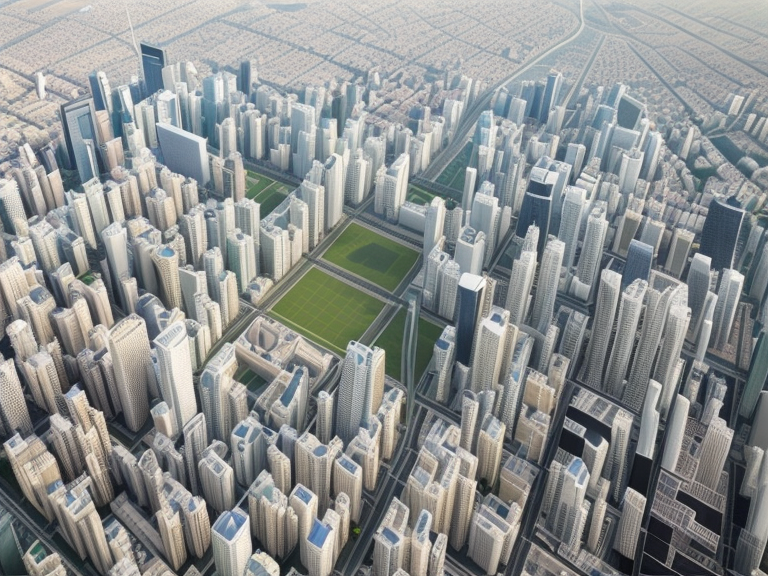

In [45]:
# Generate Image
prompt = """Ultra-realistic aerial view of a modern city, captured from a high-resolution satellite or drone. Skyscrapers, residential areas, roads, and parks are detailed and proportional, with natural lighting and depth. No distortions, warped buildings, or AI artifacts. Clear atmosphere with soft haze near the horizon."""
negative_prompt = "Distorted buildings, warped roads, AI artifacts, unnatural lighting, low detail, fisheye effect."

# Run Stable Diffusion with ControlNets
output = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=[depth_map, edge_map, ade20k_map],
    num_inference_steps=50,
    guidance_scale=7.5,
    controlnet_conditioning_scale=[1.0, 0.9, 0.8],
)

# Save output
output.images[0]